In [2]:
import warnings

# Ignore DeprecationWarning only
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Ignore UserWarning with a specific message
warnings.filterwarnings('ignore', message="Argument `input_length` is deprecated")


In [3]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Dropout, BatchNormalization
from keras.layers import Flatten, RepeatVector
from sklearn.metrics import mean_absolute_error, mean_squared_error

current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)

/home/ladans/DNN/Project/Optimized_model
/home/ladans/DNN/Project/Optimized_model/Dataset


In [9]:
# Directory containing CSV files
data_dir = dir_base

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    stock_symbol = os.path.basename(file_path).split('.')[0]
    df = pd.read_csv(file_path)
    df['Stock_Symbol'] = stock_symbol
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by date and stock symbol
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])

# Normalize prices using MinMaxScaler across all stocks
scaler = MinMaxScaler(feature_range=(0, 1))
all_data['Normalized_Close'] = all_data.groupby('Stock_Symbol')['Close'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

all_data.head()

,Date,Open,Close,Stock_Symbol,Stock_Index,Normalized_Close
0,2012-09-04,95.108574,96.424286,AAPL,0,0.375340
1,2012-09-05,96.510002,95.747147,AAPL,0,0.369085
2,2012-09-06,96.167145,96.610001,AAPL,0,0.377055
3,2012-09-07,96.864288,97.205711,AAPL,0,0.382558
4,2012-09-10,97.207146,94.677139,AAPL,0,0.359201


In [5]:
warnings.filterwarnings('ignore')

In [6]:
import optuna
import numpy as np
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

# Define the Optuna objective function
def objective(trial):
    # Hyperparameter space
    sequence_length = trial.suggest_int('sequence_length', 10, 50)  # Sequence length
    embedding_size = trial.suggest_int('embedding_size', 8, 32)  # Embedding size
    lstm_units_1 = trial.suggest_int('lstm_units_1', 64, 256)  # First LSTM units
    lstm_units_2 = trial.suggest_int('lstm_units_2', 32, 128)  # Second LSTM units
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)  # Dropout rate
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])  # Batch size
    epochs = trial.suggest_int('epochs', 10, 50)  # Number of epochs

    # Create sequences with the suggested sequence_length
    X, y, stock_indices = [], [], []
    for stock in all_data['Stock_Symbol'].unique():
        stock_data = all_data[all_data['Stock_Symbol'] == stock]
        normalized_prices = stock_data['Normalized_Close'].values

        for i in range(len(normalized_prices) - sequence_length):
            X.append(normalized_prices[i: i + sequence_length])
            y.append(normalized_prices[i + sequence_length])
            stock_indices.append(stock_data['Stock_Index'].iloc[0])

    X = np.array(X).reshape((len(X), sequence_length, 1))
    y = np.array(y)
    stock_indices = np.array(stock_indices)

    # Train-test split
    train_ratio = 0.7
    validation_ratio = 0.15
    test_ratio = 0.15
    
    # Calculate split sizes
    train_size = int(len(X) * train_ratio)
    validation_size = int(len(X) * validation_ratio)
    
    # Perform the splits
    X_train = X[:train_size]
    y_train = y[:train_size]
    stock_indices_train = stock_indices[:train_size]
    
    X_val = X[train_size:train_size + validation_size]
    y_val = y[train_size:train_size + validation_size]
    stock_indices_val = stock_indices[train_size:train_size + validation_size]
    
    X_test = X[train_size + validation_size:]
    y_test = y[train_size + validation_size:]
    stock_indices_test = stock_indices[train_size + validation_size:]
    
    # Reshape inputs for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the model
    num_stocks = len(all_data['Stock_Symbol'].unique())

    price_input = Input(shape=(sequence_length, 1), name='price_input')
    stock_input = Input(shape=(1,), name='stock_input')

    stock_embedding = Embedding(input_dim=num_stocks, output_dim=embedding_size, input_length=1)(stock_input)
    stock_embedding = Flatten()(stock_embedding)
    stock_embedding = RepeatVector(sequence_length)(stock_embedding)

    merged_input = Concatenate(axis=2)([price_input, stock_embedding])
    lstm_out = LSTM(units=lstm_units_1, return_sequences=True)(merged_input)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    lstm_out = LSTM(units=lstm_units_2, return_sequences=False)(lstm_out)
    output = Dense(units=1, activation="linear")(lstm_out)

    model = Model(inputs=[price_input, stock_input], outputs=output)
    optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss="mean_absolute_error")

    # Train the model
    model.fit([X_train, stock_indices_train], y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    predictions = model.predict([X_val, stock_indices_val], verbose=0)
    mae = mean_absolute_error(y_val, predictions)

    return mae  # Return the metric to minimize

# Create and run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Run 10 trials

# Print the best hyperparameters
print("Best hyperparameters:")
print(study.best_params)


[I 2024-12-04 13:28:25,108] A new study created in memory with name: no-name-fcd591e0-6451-41ea-a8ef-90c2cd64036e
W0000 00:00:1733318905.203206  674698 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-04 13:28:26.860334: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
[I 2024-12-04 13:29:14,556] Trial 0 finished with value: 0.011697442320606499 and parameters: {'sequence_length': 21, 'embedding_size': 15, 'lstm_units_1': 103, 'lstm_units_2': 67, 'dropout_rate': 0.14629933017871177, 'batch_size': 64, 'epochs': 24}. Best is trial 0 with value: 0.011697442320606499.
[I 2024-12-04 13:30:45,365] Tr

Best hyperparameters:
{'sequence_length': 48, 'embedding_size': 29, 'lstm_units_1': 161, 'lstm_units_2': 70, 'dropout_rate': 0.33460491661997144, 'batch_size': 16, 'epochs': 31}


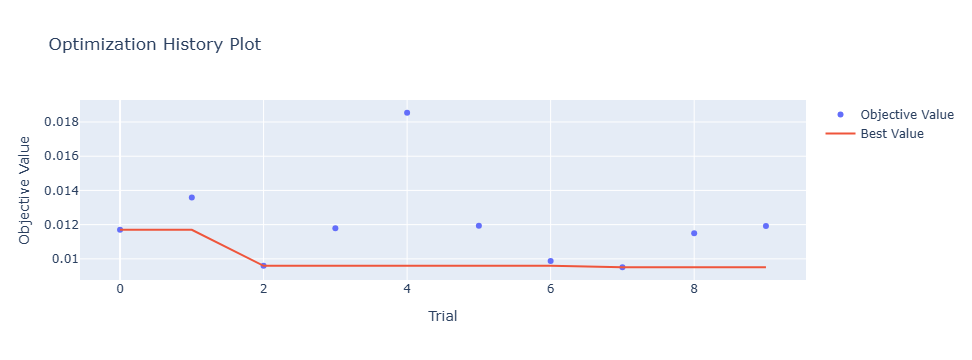

In [8]:
from optuna.visualization import plot_optimization_history

fig = plot_optimization_history(study)
fig.show()
fig.write_html("optimization_history.html")